In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [105]:
import os
import glob
import sys
import pandas as pd
module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
from ipv_workbench.translators import panelizer
from ipv_workbench.utilities import utils, time_utils
from ipv_workbench.translators import mapping_irradiance as ipv_irrad
from ipv_workbench.translators import module_mapping as ipv_mm
from ipv_workbench.sample import dummies
from ipv_workbench.solver import calculations as ipv_calc
from ipv_workbench.solver import simulations_mp as ipv_sim_mp
from ipv_workbench.solver import compile_mp
from ipv_workbench.solver import single_module_mp
from ipv_workbench.solver import topology_solver as ipv_ts
from ipv_workbench.visualize import plots as ipv_plots
from ipv_workbench.devices import devices
import pickle
from pprint import pprint
import numpy as np
import pvlib
import matplotlib.pyplot as plt
import random
import sympy
import copy
import proplot as pplt

# Initial Panelizer for Building/Scenario

In [37]:
PROJECT_FOLDER = "/Users/jmccarty/Desktop/bano_simulations"
BUILDING ="B1391"
CELLTECHNOLOGY = "A" #A,mono B,poly, C,cdte, D,cigs, E,asi
ORIENTATION = "P" #P=portrait, L=Landscape
FRONTCOVER = "solar_glass" #solar_glass, light_grey, basic_white

raw_panelizer_file = f"{CELLTECHNOLOGY}{ORIENTATION}_{FRONTCOVER}_{BUILDING}_raw.pickle"
completed_panelizer_file = f"{CELLTECHNOLOGY}{ORIENTATION}_{FRONTCOVER}_{BUILDING}_completed.pickle"

pickle_in = os.path.join(PROJECT_FOLDER,"panelizer",BUILDING,raw_panelizer_file)
pickle_out = os.path.join(PROJECT_FOLDER,"systems",BUILDING,raw_panelizer_file)
po = panelizer.PanelizedObject(pickle_in)
po.project_setup(PROJECT_FOLDER)
po.set_analysis_period(2000,3000,1)
# file_p = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/ipv_workbench/devices/default_devices/cell_parameters_default_monocrystalline.txt"
custom_device_data = pd.read_csv(po.MODULE_CELL_DATA, index_col='scenario').loc[f"{CELLTECHNOLOGY}{ORIENTATION}"].to_dict()
po.cell = devices.Cell(custom_device_data)


# Solve Module IV Curves

In [39]:
panelizer.solve_object_module_iv(po, mp=True)

{1391;0;10;6}
Multiprocessing the timeseries within the module list of length 3
    -----------
Time elapsed for string {1391;0;10;6}: 1.34s
{1391;0;10} {1391;0;10;6} {1391;0;10;6;0}
    -----------
Time elapsed for string {1391;0;10;6}: 1.32s
{1391;0;10} {1391;0;10;6} {1391;0;10;6;1}
    -----------
Time elapsed for string {1391;0;10;6}: 2.32s
{1391;0;10} {1391;0;10;6} {1391;0;10;6;2}
{1391;0;10;2}
Multiprocessing the timeseries within the module list of length 2
    -----------
Time elapsed for string {1391;0;10;2}: 1.3s
{1391;0;10} {1391;0;10;2} {1391;0;10;2;1}
    -----------
Time elapsed for string {1391;0;10;2}: 1.32s
{1391;0;10} {1391;0;10;2} {1391;0;10;2;0}
{1391;0;10;8}
Multiprocessing across the module list of length 19
    -----------
Time elapsed for string {1391;0;10;8}: 13.07s
{1391;0;10;4}
Multiprocessing across the module list of length 8
    -----------
Time elapsed for string {1391;0;10;4}: 8.41s
{1391;0;10;1}
Multiprocessing the timeseries within the module list of l

# Write

In [40]:

# TODO this is doing some work that is repeated
po.transfer_initial()

In [118]:
for surface in po.get_surfaces():
    for topology in po.simulation_suite_topologies:    
        po.topology = topology
        if topology=='micro_inverter':
            for string in po.get_strings(surface):
                po.write_first_level_results(surface, string)
        else:
            po.write_first_level_results(surface)

/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/ipv_workbench/solver/simulations.py:220: RuntimeWarning: invalid value encountered in divide
  Pv = dP / dV  # size is (2, 1)


In [ ]:
for topology in po.simulation_suite_topologies:
    print(f"    Starting {topology}")
    po.topology = topology
    for surface in po.get_surfaces():
        
        if po.topology=='micro_inverter':
            for string in po.get_strings(surface):
                po.write_up_string_results(surface, string)

        po.write_up_surface_results(surface)

    po.write_up_object_results()

# Results

In [117]:
po.get_dict_instance([surface,string])['YIELD']['central_inverter']['pmp']

{2999: 0.0}

In [122]:
po.get_tabular_results([surface,po.get_strings(surface)[0]],topology='central_inverter',
                      analysis_period=None, rename_cols=False)

,irrad,vmp,imp,eff,pmp
2023-03-25 08:00:00,153890.9,70.214,4.27596,0.002,300.232
2023-03-25 09:00:00,230289.1,68.711,6.35352,0.002,436.557
2023-03-25 10:00:00,264142.8,67.854,7.29562,0.002,495.037
2023-03-25 11:00:00,236959.3,68.233,6.61225,0.002,451.174
2023-03-25 12:00:00,185846.3,69.754,5.26128,0.002,366.995
...,...,...,...,...,...
2023-05-05 19:00:00,1089.3,0.000,0.00000,0.000,0.000
2023-05-05 20:00:00,0.0,0.000,0.00000,0.000,0.000
2023-05-05 21:00:00,0.0,0.000,0.00000,0.000,0.000
2023-05-05 22:00:00,0.0,0.000,0.00000,0.000,0.000


<a list of 1 Line2D objects>

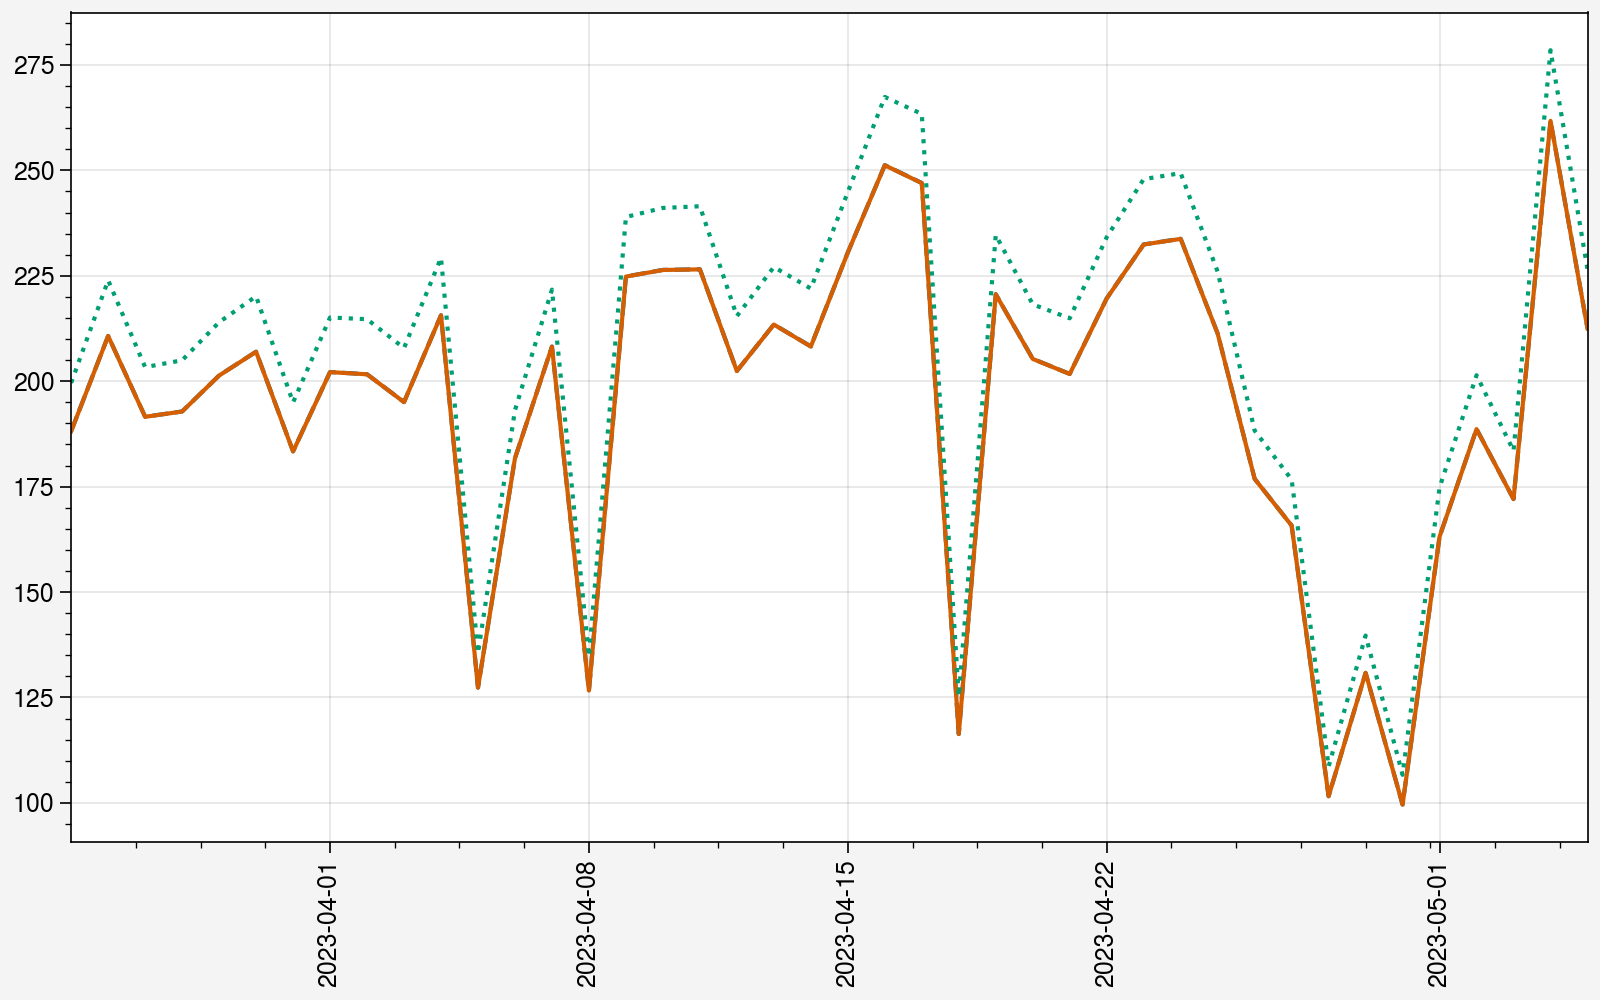

In [123]:
surface = po.get_surfaces()[1]
string = po.get_strings(surface)[0]
module = po.get_modules(surface,string)[0]


# fig, axe = pplt.subplots(ncols=2, nrows=1)

topo = 'micro_inverter'
a = po.get_tabular_results([surface,po.get_strings(surface)[0]],topology=topo,
                      analysis_period=None, rename_cols=False)[['pmp']].resample('D').sum()


topo = 'string_inverter'
b = po.get_tabular_results([surface,po.get_strings(surface)[0]],topology=topo,
                      analysis_period=None, rename_cols=False)[['pmp']].resample('D').sum()

topo = 'central_inverter'
c = po.get_tabular_results([surface,po.get_strings(surface)[0]],topology=topo,
                      analysis_period=None, rename_cols=False)[['pmp']].resample('D').sum()


fig,axes = pplt.subplots(ncols=1,nrows=1,figsize=(8,5))

ax = axes[0]

ax.line(a, linestyle='dashed', label='string_0')
ax.line(b, linestyle='solid', label='string_1')
ax.line(c, linestyle='dotted', label='string_2')
# ax.line(d, linestyle='dashdot', label='string_3')



# Plot

In [5]:
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[1]
module = po.get_modules(surface, string)[0]
string_details = po.get_dict_instance([surface,string])['DETAILS']
curve_dict = po.get_dict_instance([surface,string,module])['CURVES']['initial_simulation']

hoy = 2222

base_parameters = utils.get_cec_data(string_details['cec_key'], file_path=po.CEC_DATA)


ipv_plots.plot_curves(curve_dict['Imod'][hoy],
                      curve_dict['Vmod'][hoy],
                      base_parameters,
                      y_max=1,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                    #   labels=f"{Gmod / 1000} kWh",
                      title=time_utils.hoy_to_date(hoy))

KeyError: 2222